# **Septin Detection** Notebook for QFM2025 Course

This notebook provides a workflow for **detecting septin rings in microscopy images**. It includes steps for dataset preparation, model training, and prediction using YOLOv8, with customizable options to fine-tune the detection process. Designed specifically for the **QFM2025 course**, it aims to make object detection in pSTORM data.

contact: amin.zehtabian@fu-berlin.de
Last Update: Jan 2025

###GPU Check + Installing necessary libraries


Execute this cell to verify **GPU** access and install some necessary **libraries**.

Note: To use a better GPU, go to the toolbar, select **Runtime**, and switch the Runtime Type to one of the available GPU options

In [2]:
!nvidia-smi
from matplotlib import image
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
#from IPython import display
#display.clear_output()
#from IPython.display import display, Image
import glob
import random
import os
!pip install tqdm   # for progress bar
from tqdm.notebook import tqdm
HOME = os.getcwd();
import torch
#display(HOME)


Thu Jan 30 09:54:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   34C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Optional: Mount **Google Drive** and get the current working directory.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#@markdown ###Path to the project (where the data and final models should be stored):
project_path = '/content/Project_Septin'#@param {type:"string"}

import os
#%cd project_path
!mkdir {project_path}
os.chdir(project_path)
HOME = os.getcwd()

# Installing YOLOv8

We are now ready to use the YOLOv8 model for training on our annotated images. **YOLOv8** supports a variety of prediction tasks, including:

- **Detection**: Drawing bounding boxes around objects.
- **Segmentation**: Outlining objects in an image.
- **Tracking**: Following objects across frames in a video.
- **Image Classification**: Categorizing images into predefined classes.
- **Pose Detection**: Estimating keypoints for human or object poses.

For our project, the focus will be on the **Detection of Septin Rings** (and later, Segmentation of rings). You can find examples and additional resources on the Ultralytics GitHub page ((https://github.com/ultralytics/ultralytics))

In [ ]:
%pip install ultralytics --quiet
import ultralytics
ultralytics.checks()

# Run Standard Pre-Trained YOLO Models on the Test Image

- Create a sub-folder named 'test' within your project folder (default: 'Project_Septin/test/').
- Place example test images into this folder.
- This cell runs a standard pre-trained YOLOv8 model on the test images. However, since the model has not been trained on data similar to your septin images, you will observe that no detection or segmentation is performed on these images.

/content


100%|██████████| 6.25M/6.25M [00:00<00:00, 420MB/s]


100%|██████████| 6.74M/6.74M [00:00<00:00, 388MB/s]



image 1/1 /content/Project_Septin/test/test.jpg: 640x640 (no detections), 8.2ms
Speed: 14.5ms preprocess, 8.2ms inference, 78.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/Project_Septin/test/test.jpg: 640x640 (no detections), 8.7ms
Speed: 3.7ms preprocess, 8.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


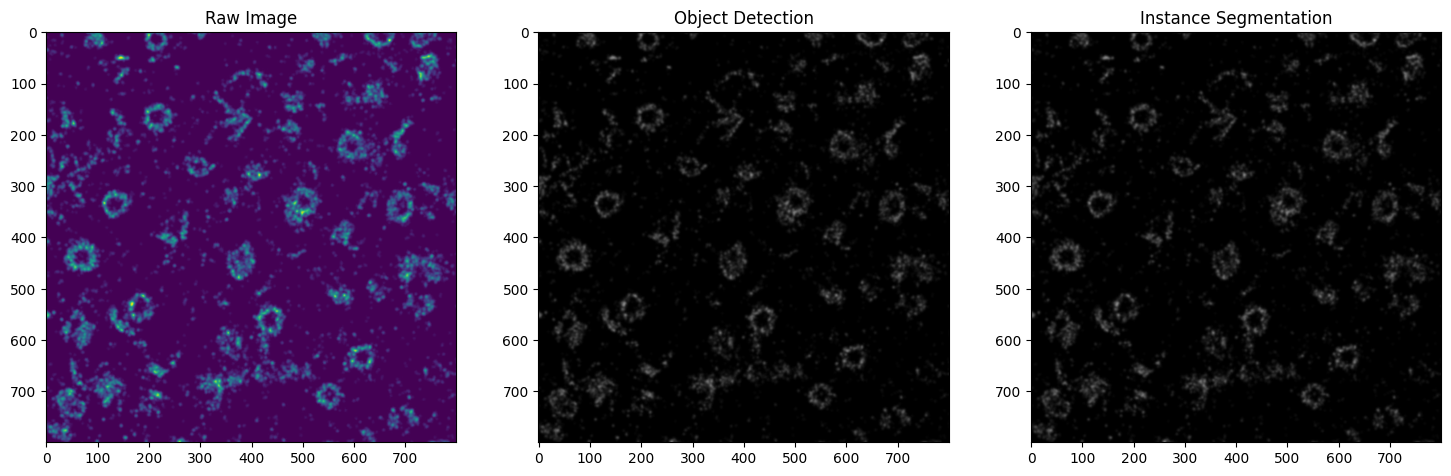

In [6]:
from ultralytics import YOLO

#%cd {HOME}/test
Test_Image1 = '/content/Project_Septin/test/test.jpg'
#plt.imshow(image.imread(Test_Image1))

%cd {HOME}
# Standard pre-trained model for detection
model_detection = YOLO('yolov8n.pt')
# Standard pre-trained model for segmentation
model_segmentation = YOLO('yolov8n-seg.pt')

# Run the standard pre-trained models for detection and segmentation
prediction_detection = model_detection.predict(Test_Image1)
prediction_segmentation = model_segmentation.predict(Test_Image1)
# Visualization
detection_result_array = prediction_detection[0].plot()
instance_result_array = prediction_segmentation[0].plot()


fig = plt.figure(figsize=(18, 9))
ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Raw Image")
plt.imshow(image.imread(Test_Image1))
ax2 = fig.add_subplot(1,3,2)
ax2.set_title("Object Detection")
ax2.imshow(detection_result_array)
ax3 = fig.add_subplot(1,3,3)
ax3.set_title("Instance Segmentation")
ax3.imshow(instance_result_array)

# Training → Step #1: Importing the Training Dataset from Roboflow

To enable the model to recognize microscopy images containing septin rings, we need to train the model further (also known as **fine-tuning**) using a suitable training dataset. If you don’t have a pre-existing dataset, you will need to create one and annotate the training images.

There are several tools available for annotating objects in images, and the choice of tool depends on the type of annotation required. For example, annotations for object detection differ from those needed for segmentation. One of the simplest and most effective tools for annotation is **Roboflow** (https://roboflow.com/).

To help you get started, I have prepared a PowerPoint file with detailed instructions on creating training samples. Once you have created a custom training dataset using Roboflow, simply copy and paste your **API_KEY** into the code below to integrate it into your project.

In [7]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets
!pip install roboflow --quiet

from roboflow import Roboflow
rf = Roboflow(api_key="0o69ClS8r4Cwtju09p6Y")
project = rf.workspace("agewers-30oij").project("septindetection")
version = project.version(1)
dataset = version.download("yolov8")

/content/Project_Septin/datasets
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 46.0 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to SeptinDetection-1 in yolov8:: 100%|██████████| 65/65 [00:00<00:00, 7003.08it/s]


# Training → Step #2: Modifying the data.yaml file

The training dataset has been successfully imported from the Roboflow cloud repository.

**Note 1:**
You can access the training, validation, and test images under the folder '**/datasets/**'. Detailed information about the datasets, such as paths and class labels, can be found in the file **data.yaml**.

**Note 2:**
In some versions of YOLOv8, you might encounter an error indicating that the model cannot locate the training and validation folders. To resolve this issue, open the **data.yaml** file and make a small modification. Update the paths to the following training and validation datasets to ensure they are correctly referenced:

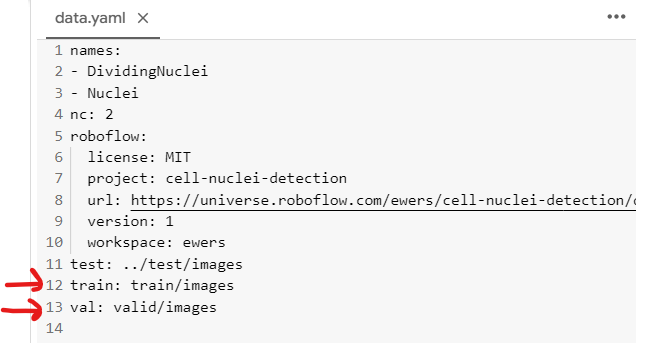

# Training → Step #3: Parameter Setting for Training

Here we need to set some training parameters, including the exact YOLOv8 pre-trained model we are going to fune-tune further.

We may begin training with the **YOLOv8s.pt model**, which is the "small" version of YOLOv8 designed for object detection. This model provides a balance between speed and accuracy, making it suitable for many applications.

Note:
You are welcome to experiment with other YOLOv8 models based on your requirements:

Less complex models:
- YOLOv8n.pt (nano): Prioritizes speed and efficiency, suitable for resource-constrained environments.

More complex models:
- YOLOv8m.pt (medium): Offers improved accuracy at the cost of slightly higher computational requirements.
- YOLOv8l.pt (large): Focuses on higher accuracy and is suitable for high-powered setups.
- YOLOv8x.pt (extra-large): Provides the best accuracy but requires significant computational resources.

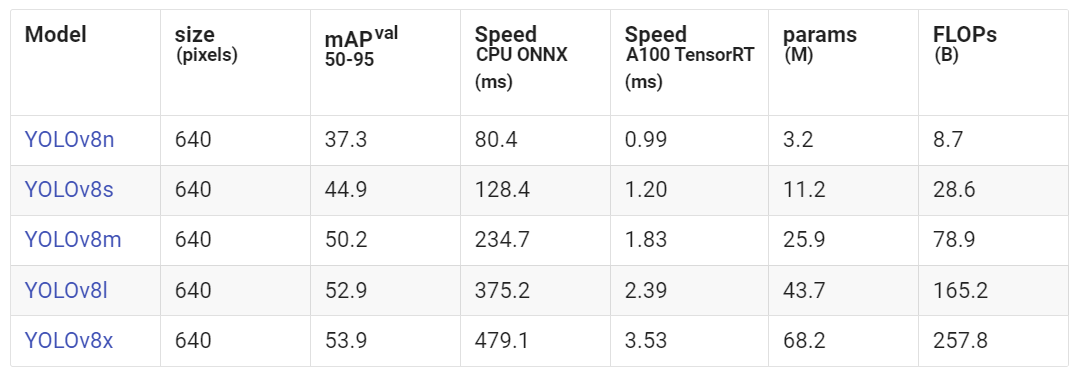

Feel free to play with **training parameters & settings** such as the number of epochs, image size, etc.


In [8]:


#Training_source = base_path + "/data/Stardist/Training - Images" #@param {type:"string"}
#Training_target = base_path + "/data/Stardist/Training - Masks" #@param {type:"string"}

#@markdown ###Name and path to the final trained model:

trained_model_name = "SeptinDetection_Model1_ep100" #@param {type:"string"}

trained_model_path = project_path + "/Models" #@param {type:"string"}
#trained_model = model_path

#project_folder_name = 'CytoYOLOv8_RectLabel' #@param {type:"string"}
#result_folder_name = 'SemiSparse_modelS_ep200_ba8_'#@param {type:"string"}

#@markdown ### Choose between the pretrained YOLO detection models (n, s, m, l , x):
YOLO_model_type= 'm'#@param {type:"string"}
#@markdown ### Other parameters for training:
epochs =  100#@param {type:"number"}
batch_size =  4#@param {type:"number"}
initial_learning_rate = 0.01#@param {type:"number"}
patch_width = 200#@param {type:"number"}
patch_height = 200#@param {type:"number"}
imgsz = (patch_width,patch_height)

# Training → Step #4: Model Training

Finally, it's time for training (fine-tuning) the YOLOv8 on our data!

In [9]:
from ultralytics import YOLO

optimizer = 'auto' # SGD, Adam, AdamW, NAdam, RAdam, RMSProp or auto
plots= True  # Generates and saves plots of training and validation metrics, as well as prediction examples
#model = YOLO('yolov8n.pt')  # load a pretrained YOLO detection model (n, s, m, l , x)
model_pt = 'yolov8'+YOLO_model_type+'.pt'
model = YOLO(model_pt)
#@markdown ###Path to the YAML file
yaml_address = '/content/Project_Septin/datasets/SeptinDetection-1/data.yaml'#@param {type:"string"}
model.train(data=yaml_address, epochs=epochs, batch=batch_size, lr0= initial_learning_rate, imgsz=imgsz, save=True, pretrained=True,optimizer=optimizer, plots = plots)  # train the model

100%|██████████| 49.7M/49.7M [00:00<00:00, 392MB/s]


Ultralytics 8.3.69 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/Project_Septin/datasets/SeptinDetection-1/data.yaml, epochs=100, time=None, patience=100, batch=4, imgsz=(200, 200), save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, sh

100%|██████████| 755k/755k [00:00<00:00, 86.2MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 200MB/s]


AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=200'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'
WARNING ⚠️ imgsz=[200] must be multiple of max stride 32, updating to [224]


train: Scanning /content/Project_Septin/datasets/SeptinDetection-1/train/labels... 24 images, 0 backgrounds, 0 corrupt: 100%|██████████| 24/24 [00:00<00:00, 1304.06it/s]

train: New cache created: /content/Project_Septin/datasets/SeptinDetection-1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
val: Scanning /content/Project_Septin/datasets/SeptinDetection-1/valid/labels... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 355.62it/s]

val: New cache created: /content/Project_Septin/datasets/SeptinDetection-1/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.864G      2.541      3.956      1.138         40        224: 100%|██████████| 6/6 [00:01<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all          4         17     0.0145      0.471      0.021     0.0119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.631G      2.316      4.131      1.137         36        224: 100%|██████████| 6/6 [00:00<00:00, 11.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.00it/s]

                   all          4         17     0.0148      0.471     0.0221     0.0116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.631G      2.355      4.088      1.135         31        224: 100%|██████████| 6/6 [00:00<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.57it/s]

                   all          4         17     0.0125      0.412     0.0208      0.011



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.841G      1.924      4.659      1.017         24        224: 100%|██████████| 6/6 [00:00<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 19.90it/s]

                   all          4         17      0.169      0.235      0.102     0.0402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.841G      2.028      2.448       1.02         48        224: 100%|██████████| 6/6 [00:00<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.02it/s]

                   all          4         17     0.0713      0.235     0.0306    0.00972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.841G      1.901       1.28     0.9816         40        224: 100%|██████████| 6/6 [00:00<00:00, 11.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.69it/s]

                   all          4         17      0.561      0.412      0.438      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.841G      2.143      1.394       1.07         31        224: 100%|██████████| 6/6 [00:00<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.19it/s]

                   all          4         17    0.00825      0.294     0.0054    0.00215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.841G       1.86       1.31     0.9786         52        224: 100%|██████████| 6/6 [00:00<00:00, 11.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.59it/s]

                   all          4         17    0.00825      0.294     0.0054    0.00215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.841G      1.941       1.72     0.9671         30        224: 100%|██████████| 6/6 [00:00<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.52it/s]

                   all          4         17     0.0775      0.353     0.0509     0.0216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.841G      2.055      2.449      1.007         20        224: 100%|██████████| 6/6 [00:00<00:00, 11.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.55it/s]

                   all          4         17      0.125      0.824      0.109     0.0426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.841G      2.022      1.382      1.027         29        224: 100%|██████████| 6/6 [00:00<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.14it/s]

                   all          4         17      0.125      0.824      0.109     0.0426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.841G      1.966      1.238     0.9574         38        224: 100%|██████████| 6/6 [00:00<00:00, 11.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.69it/s]

                   all          4         17      0.225      0.706      0.203     0.0665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.841G       2.24      1.151     0.9842         28        224: 100%|██████████| 6/6 [00:00<00:00, 11.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.69it/s]

                   all          4         17      0.225      0.706      0.203     0.0665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.841G      2.087      1.124     0.9776         24        224: 100%|██████████| 6/6 [00:00<00:00, 11.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.08it/s]

                   all          4         17      0.225      0.706      0.203     0.0665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.843G      2.129      1.098      1.005         35        224: 100%|██████████| 6/6 [00:00<00:00, 11.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.69it/s]

                   all          4         17      0.596      0.694      0.602       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.841G      2.218      1.117     0.9788         45        224: 100%|██████████| 6/6 [00:00<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.89it/s]

                   all          4         17      0.596      0.694      0.602       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.841G      2.114      1.155      1.039         25        224: 100%|██████████| 6/6 [00:00<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.94it/s]

                   all          4         17      0.404      0.647       0.34       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.841G        2.1      1.146      1.028         28        224: 100%|██████████| 6/6 [00:00<00:00, 11.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.49it/s]

                   all          4         17      0.404      0.647       0.34       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.841G      2.065       1.12      1.019         33        224: 100%|██████████| 6/6 [00:00<00:00, 11.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.76it/s]

                   all          4         17      0.404      0.647       0.34       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.843G       1.98      1.039     0.9886         47        224: 100%|██████████| 6/6 [00:00<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.77it/s]

                   all          4         17      0.324      0.588      0.291      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.841G      1.789     0.9574     0.9413         38        224: 100%|██████████| 6/6 [00:00<00:00, 11.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.87it/s]

                   all          4         17      0.324      0.588      0.291      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.841G      1.721     0.9096      0.951         31        224: 100%|██████████| 6/6 [00:00<00:00, 11.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.01it/s]

                   all          4         17      0.324      0.588      0.291      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.841G      1.823     0.9871      0.949         27        224: 100%|██████████| 6/6 [00:00<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.81it/s]

                   all          4         17      0.231      0.706      0.211     0.0874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.843G      1.964      1.051     0.9565         27        224: 100%|██████████| 6/6 [00:00<00:00, 11.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.67it/s]

                   all          4         17      0.231      0.706      0.211     0.0874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.841G      1.971      1.022      0.971         31        224: 100%|██████████| 6/6 [00:00<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.23it/s]

                   all          4         17      0.347      0.706      0.263      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.841G      1.763      1.005     0.9402         42        224: 100%|██████████| 6/6 [00:00<00:00, 11.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.39it/s]

                   all          4         17      0.347      0.706      0.263      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.843G      1.758     0.9797     0.9587         31        224: 100%|██████████| 6/6 [00:00<00:00, 11.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.76it/s]

                   all          4         17      0.347      0.706      0.263      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.841G       1.67     0.9148     0.9163         44        224: 100%|██████████| 6/6 [00:00<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.63it/s]

                   all          4         17      0.923      0.703       0.82       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.841G      1.706     0.9594     0.9116         22        224: 100%|██████████| 6/6 [00:00<00:00, 11.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.18it/s]

                   all          4         17      0.923      0.703       0.82       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.843G       1.63     0.8493     0.9218         42        224: 100%|██████████| 6/6 [00:00<00:00, 11.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.39it/s]

                   all          4         17      0.923      0.703       0.82       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.841G      1.666      0.909     0.9505         40        224: 100%|██████████| 6/6 [00:00<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.18it/s]

                   all          4         17      0.981      0.647      0.845      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.843G      1.744     0.9139     0.9414         31        224: 100%|██████████| 6/6 [00:00<00:00, 12.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.87it/s]

                   all          4         17      0.981      0.647      0.845      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.841G      1.607     0.8718     0.9237         37        224: 100%|██████████| 6/6 [00:00<00:00, 11.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.84it/s]

                   all          4         17       0.93      0.788      0.906      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.841G      1.584     0.8105     0.8879         51        224: 100%|██████████| 6/6 [00:00<00:00, 11.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.09it/s]

                   all          4         17       0.93      0.788      0.906      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.841G      1.605     0.9413      0.915         39        224: 100%|██████████| 6/6 [00:00<00:00, 11.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.21it/s]

                   all          4         17       0.93      0.788      0.906      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.841G      1.585     0.8125     0.9249         47        224: 100%|██████████| 6/6 [00:00<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.72it/s]

                   all          4         17      0.698      0.765      0.831      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.841G      1.577     0.8829     0.9117         34        224: 100%|██████████| 6/6 [00:00<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.09it/s]

                   all          4         17      0.698      0.765      0.831      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.841G      1.499      0.825      0.942         24        224: 100%|██████████| 6/6 [00:00<00:00, 11.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.53it/s]

                   all          4         17      0.698      0.765      0.831      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.841G      1.617     0.8582     0.8994         33        224: 100%|██████████| 6/6 [00:00<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.75it/s]

                   all          4         17      0.894      0.647      0.848       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.841G      1.522     0.8669     0.9336         28        224: 100%|██████████| 6/6 [00:00<00:00, 11.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.40it/s]

                   all          4         17      0.894      0.647      0.848       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.843G      1.546     0.8994     0.9213         50        224: 100%|██████████| 6/6 [00:00<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.13it/s]

                   all          4         17      0.922      0.695      0.866      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.841G      1.495     0.8518     0.9314         30        224: 100%|██████████| 6/6 [00:00<00:00, 11.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.54it/s]

                   all          4         17      0.922      0.695      0.866      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.843G      1.514     0.7953     0.8829         30        224: 100%|██████████| 6/6 [00:00<00:00, 11.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.22it/s]

                   all          4         17      0.922      0.695      0.866      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.841G      1.471     0.8028     0.8996         19        224: 100%|██████████| 6/6 [00:00<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.13it/s]

                   all          4         17      0.922      0.699      0.819      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.841G      1.524     0.8348     0.8947         34        224: 100%|██████████| 6/6 [00:00<00:00, 11.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.60it/s]

                   all          4         17      0.922      0.699      0.819      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.841G      1.489     0.7841     0.9192         25        224: 100%|██████████| 6/6 [00:00<00:00, 11.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 19.98it/s]

                   all          4         17      0.922      0.699      0.819      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.841G      1.583     0.8363      0.906         37        224: 100%|██████████| 6/6 [00:00<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.97it/s]

                   all          4         17      0.906      0.647      0.803      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.843G      1.577     0.8571     0.8961         17        224: 100%|██████████| 6/6 [00:00<00:00, 11.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.52it/s]

                   all          4         17      0.906      0.647      0.803      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.841G      1.504     0.8338      0.891         49        224: 100%|██████████| 6/6 [00:00<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.28it/s]

                   all          4         17      0.739      0.833      0.845      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100     0.841G       1.51     0.8598     0.8994         19        224: 100%|██████████| 6/6 [00:00<00:00, 11.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.69it/s]

                   all          4         17      0.739      0.833      0.845      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.841G      1.505     0.8283     0.8999         32        224: 100%|██████████| 6/6 [00:00<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.79it/s]

                   all          4         17      0.739      0.833      0.845      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.841G      1.518     0.7945     0.8913         40        224: 100%|██████████| 6/6 [00:00<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.46it/s]

                   all          4         17       0.91      0.765      0.829      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.841G      1.406     0.7468     0.8895         29        224: 100%|██████████| 6/6 [00:00<00:00, 11.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.28it/s]

                   all          4         17       0.91      0.765      0.829      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.841G      1.626      0.839     0.9114         33        224: 100%|██████████| 6/6 [00:00<00:00, 11.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.46it/s]

                   all          4         17       0.91      0.765      0.829      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100     0.841G      1.564      0.768     0.9093         33        224: 100%|██████████| 6/6 [00:00<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.33it/s]

                   all          4         17      0.706      0.706      0.768      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.841G      1.589     0.8429     0.8864         25        224: 100%|██████████| 6/6 [00:00<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.26it/s]

                   all          4         17      0.706      0.706      0.768      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100     0.843G      1.441     0.7387     0.8704         26        224: 100%|██████████| 6/6 [00:00<00:00, 11.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.41it/s]

                   all          4         17      0.824      0.882       0.93      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.841G      1.444     0.7223     0.8942         30        224: 100%|██████████| 6/6 [00:00<00:00, 11.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.89it/s]

                   all          4         17      0.824      0.882       0.93      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.841G      1.468     0.7589     0.8888         38        224: 100%|██████████| 6/6 [00:00<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.12it/s]

                   all          4         17      0.824      0.882       0.93      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.841G      1.435     0.7475     0.8995         27        224: 100%|██████████| 6/6 [00:00<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.29it/s]

                   all          4         17      0.927      0.882      0.896      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.841G      1.456     0.7849     0.8923         25        224: 100%|██████████| 6/6 [00:00<00:00, 12.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.95it/s]

                   all          4         17      0.927      0.882      0.896      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100     0.841G      1.452     0.8242     0.8911         59        224: 100%|██████████| 6/6 [00:00<00:00, 12.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.01it/s]

                   all          4         17      0.927      0.882      0.896      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100     0.841G      1.547     0.8404     0.8759         34        224: 100%|██████████| 6/6 [00:00<00:00, 10.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.86it/s]

                   all          4         17      0.976      0.941      0.967      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.841G      1.441     0.7263     0.8934         18        224: 100%|██████████| 6/6 [00:00<00:00, 11.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.64it/s]

                   all          4         17      0.976      0.941      0.967      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.841G      1.456     0.7431     0.9027         33        224: 100%|██████████| 6/6 [00:00<00:00, 11.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.27it/s]

                   all          4         17      0.921      0.941      0.969      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100     0.841G      1.418      0.748     0.8935         35        224: 100%|██████████| 6/6 [00:00<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.42it/s]

                   all          4         17      0.921      0.941      0.969      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100     0.841G      1.371     0.7304     0.8731         24        224: 100%|██████████| 6/6 [00:00<00:00, 11.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.29it/s]

                   all          4         17      0.921      0.941      0.969      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.841G      1.515     0.8086     0.8735         51        224: 100%|██████████| 6/6 [00:00<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.74it/s]

                   all          4         17      0.921      0.882      0.961      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.841G        1.5     0.7901     0.8918         30        224: 100%|██████████| 6/6 [00:00<00:00, 11.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.42it/s]

                   all          4         17      0.921      0.882      0.961      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.841G       1.46     0.7571     0.8976         28        224: 100%|██████████| 6/6 [00:00<00:00, 11.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.53it/s]

                   all          4         17      0.921      0.882      0.961      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.843G      1.399     0.6841     0.8908         36        224: 100%|██████████| 6/6 [00:00<00:00, 11.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.77it/s]

                   all          4         17      0.937      0.882      0.958      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.841G      1.376      0.845     0.9076         47        224: 100%|██████████| 6/6 [00:00<00:00, 11.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.44it/s]

                   all          4         17      0.937      0.882      0.958      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.841G      1.355     0.7159     0.8754         42        224: 100%|██████████| 6/6 [00:00<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 19.20it/s]

                   all          4         17      0.865      0.824      0.945      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.843G      1.423     0.7329     0.8924         45        224: 100%|██████████| 6/6 [00:00<00:00, 11.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.48it/s]

                   all          4         17      0.865      0.824      0.945      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.843G       1.39     0.7029     0.8872         29        224: 100%|██████████| 6/6 [00:00<00:00, 12.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.94it/s]

                   all          4         17      0.865      0.824      0.945      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.841G      1.446     0.7166     0.8841         41        224: 100%|██████████| 6/6 [00:00<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.80it/s]

                   all          4         17      0.765          1      0.936      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.841G      1.483     0.7553     0.8717         50        224: 100%|██████████| 6/6 [00:00<00:00, 12.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.12it/s]

                   all          4         17      0.765          1      0.936      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100     0.843G      1.519     0.7771     0.8757         41        224: 100%|██████████| 6/6 [00:00<00:00, 11.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.66it/s]

                   all          4         17      0.765          1      0.936      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.841G      1.397     0.7274     0.8878         36        224: 100%|██████████| 6/6 [00:00<00:00, 11.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.97it/s]

                   all          4         17      0.762          1      0.931      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.841G      1.329     0.7465     0.8502         28        224: 100%|██████████| 6/6 [00:00<00:00, 11.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.29it/s]

                   all          4         17      0.762          1      0.931      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.843G      1.344     0.7942     0.8854         48        224: 100%|██████████| 6/6 [00:00<00:00, 11.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.19it/s]

                   all          4         17      0.787          1      0.922      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100     0.841G      1.425     0.7742     0.8891         43        224: 100%|██████████| 6/6 [00:00<00:00, 11.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.30it/s]

                   all          4         17      0.787          1      0.922      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100     0.841G      1.362     0.6842     0.8744         20        224: 100%|██████████| 6/6 [00:00<00:00, 11.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.49it/s]

                   all          4         17      0.787          1      0.922      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.843G      1.351     0.7493     0.8724         55        224: 100%|██████████| 6/6 [00:00<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.38it/s]

                   all          4         17      0.806      0.941      0.924      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.841G      1.445     0.8069      0.884         31        224: 100%|██████████| 6/6 [00:00<00:00, 12.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.35it/s]

                   all          4         17      0.806      0.941      0.924      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.841G      1.366     0.7398     0.8615         41        224: 100%|██████████| 6/6 [00:00<00:00, 11.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.70it/s]

                   all          4         17      0.806      0.941      0.924      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.841G      1.517     0.7745     0.9183         20        224: 100%|██████████| 6/6 [00:00<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.70it/s]

                   all          4         17      0.794          1      0.928      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.841G      1.398     0.6723     0.9122         35        224: 100%|██████████| 6/6 [00:00<00:00, 12.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.03it/s]

                   all          4         17      0.794          1      0.928      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.841G      1.258     0.6695     0.8636         36        224: 100%|██████████| 6/6 [00:00<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.61it/s]

                   all          4         17      0.842      0.938      0.938      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100     0.841G      1.319     0.7062     0.8559         28        224: 100%|██████████| 6/6 [00:00<00:00, 12.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.77it/s]

                   all          4         17      0.842      0.938      0.938      0.512


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100     0.841G      1.372      0.714     0.9148         16        224: 100%|██████████| 6/6 [00:00<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.41it/s]

                   all          4         17      0.842      0.938      0.938      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.841G      1.409     0.7447      0.918         21        224: 100%|██████████| 6/6 [00:00<00:00, 11.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.73it/s]

                   all          4         17      0.832      0.871      0.921      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.841G      1.413     0.8656     0.8473         27        224: 100%|██████████| 6/6 [00:00<00:00, 11.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.85it/s]

                   all          4         17      0.832      0.871      0.921      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100     0.841G      1.278      0.694     0.9161         25        224: 100%|██████████| 6/6 [00:00<00:00, 11.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]

                   all          4         17      0.832      0.871      0.921      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.841G      1.339     0.7345     0.9083         20        224: 100%|██████████| 6/6 [00:00<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.33it/s]

                   all          4         17      0.928       0.76      0.903      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.841G       1.26      0.649     0.8787         18        224: 100%|██████████| 6/6 [00:00<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.21it/s]

                   all          4         17      0.928       0.76      0.903      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.841G      1.428     0.7728     0.8927         23        224: 100%|██████████| 6/6 [00:00<00:00, 11.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.16it/s]

                   all          4         17      0.928      0.763      0.888      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.841G      1.306     0.6806     0.8712         28        224: 100%|██████████| 6/6 [00:00<00:00, 12.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.47it/s]

                   all          4         17      0.928      0.763      0.888      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100     0.841G      1.309     0.6512     0.8731         26        224: 100%|██████████| 6/6 [00:00<00:00, 11.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.84it/s]

                   all          4         17      0.928      0.763      0.888      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.841G      1.326     0.7412     0.9169         29        224: 100%|██████████| 6/6 [00:00<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.31it/s]

                   all          4         17      0.928      0.758      0.857      0.471



100 epochs completed in 0.049 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.69 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 218 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.54it/s]


                   all          4         17      0.977      0.941      0.967      0.571
Speed: 0.1ms preprocess, 3.4ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c0239af4810>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Prediction on Multiple Images
To perform predictions on multiple images, the user needs to provide the following inputs to the notebook:

- Path to the **.pt file**: Specify the path to the trained YOLO model file (e.g., /content/Project_Septin/datasets/runs/detect/train/weights/best.pt).
- Confidence threshold (**conf**): Define the confidence level for predictions (e.g., 0.25). Predictions with a confidence score below this threshold will be ignored.
- Folder containing test images: Provide the path to the folder where the test images are stored.

Once these inputs are provided, the notebook will process each image in the specified folder, apply the YOLO model for predictions, and output the results.

Note: The cell visualizes a single detection result. To access all the output detections, please navigate manually to the results folder.

Processing test images...


Progress:   0%|          | 0/3 [00:00<?, ?it/s]


0: 224x224 13 Septins, 10.9ms
Speed: 1.1ms preprocess, 10.9ms inference, 2.5ms postprocess per image at shape (1, 3, 224, 224)
Results saved to /content/Project_Septin/results/SeptinDetection_Model1_ep100


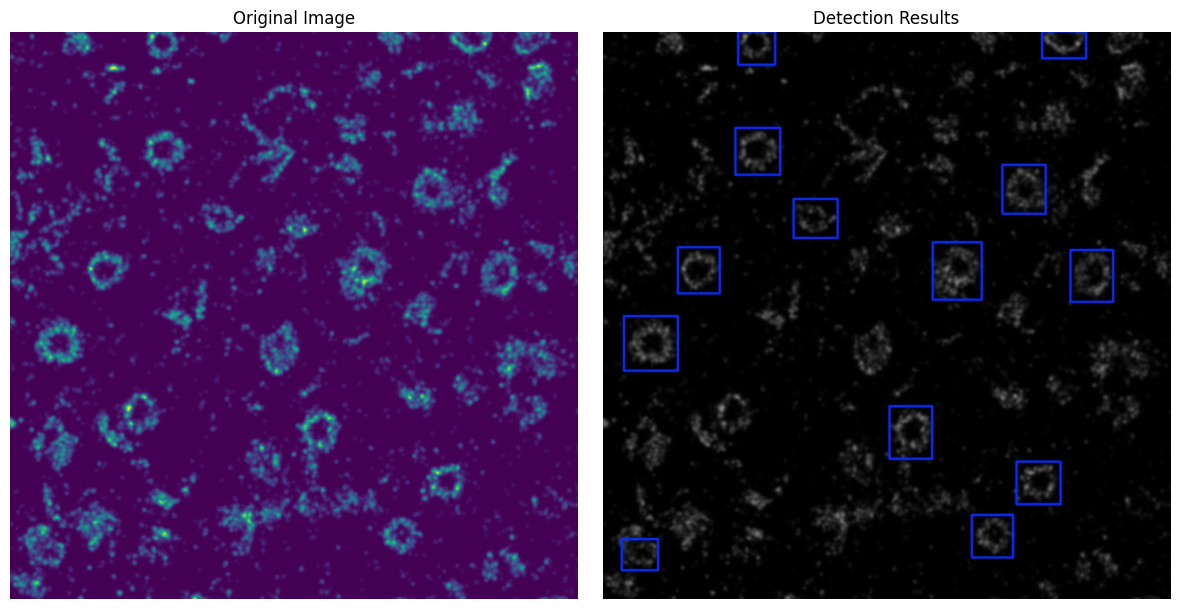

Progress:  33%|███▎      | 1/3 [00:00<00:01,  1.21it/s]


0: 224x224 13 Septins, 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 224)
Results saved to /content/Project_Septin/results/SeptinDetection_Model1_ep100


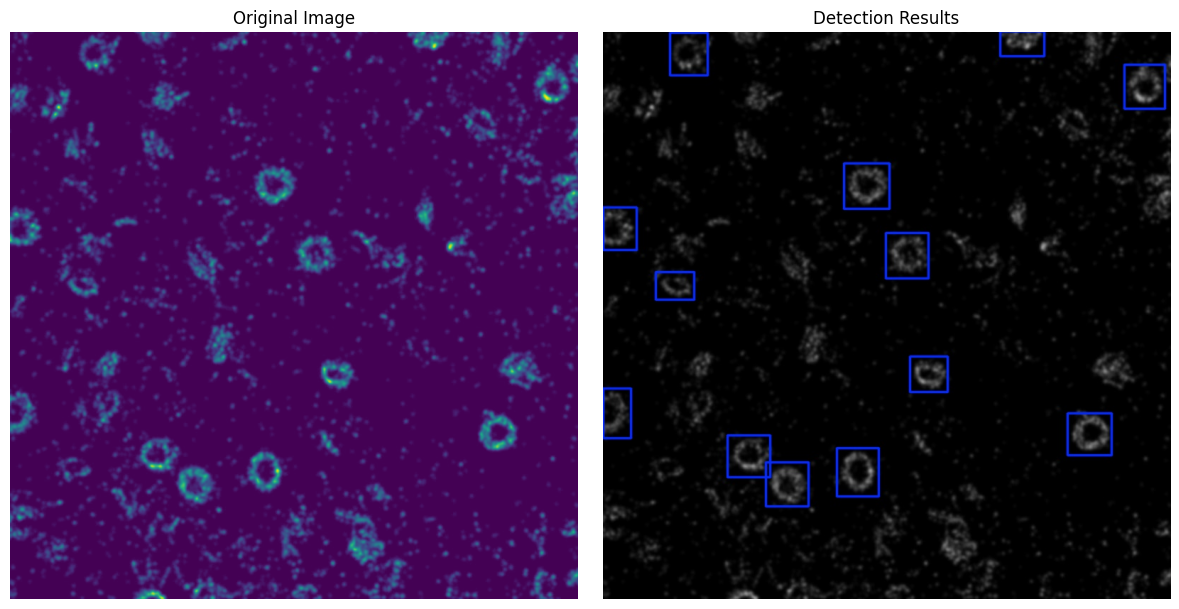

Progress:  67%|██████▋   | 2/3 [00:01<00:00,  1.62it/s]


0: 224x224 10 Septins, 10.9ms
Speed: 1.1ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 224)
Results saved to /content/Project_Septin/results/SeptinDetection_Model1_ep100


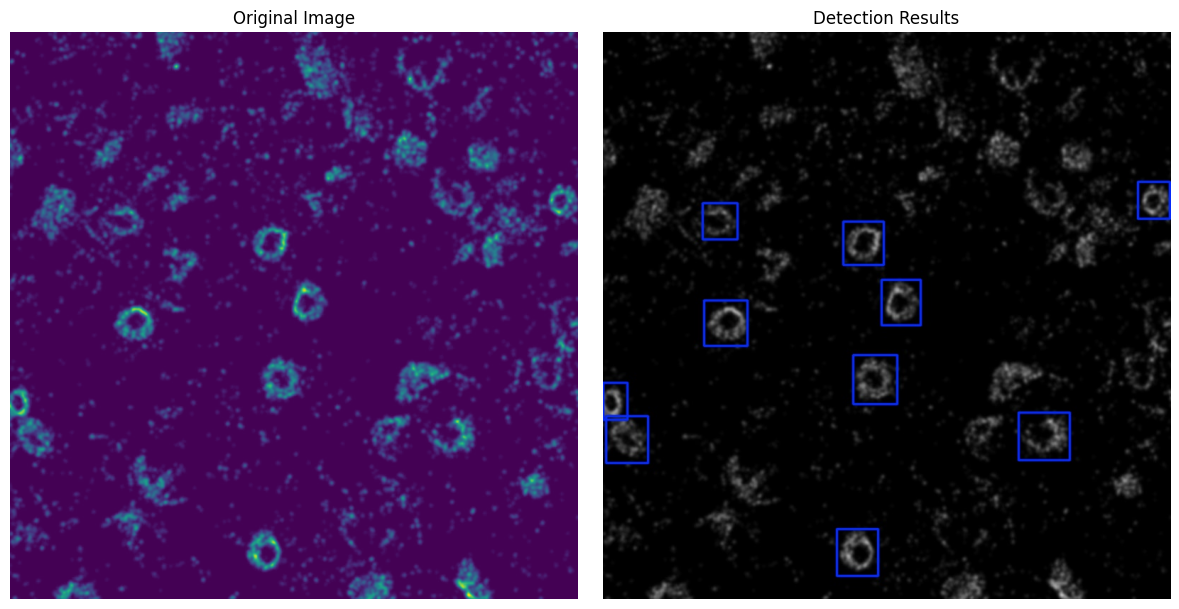

Progress: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]

*****************************************************************************************************
The prediction results are saved in --->  /content/Project_Septin/results/SeptinDetection_Model1_ep100 /
The center points are saved in --->  /content/Project_Septin/results/SeptinDetection_Model1_ep100/Centers /


In [15]:
# Specify your image dimensions, for example (200, 200)
image_shape = (patch_width, patch_height)

path_to_test_folder = '/content/Project_Septin/test'  # @param {type:"string"}
path_to_model = '/content/Project_Septin/datasets/runs/detect/train/weights/best.pt'  # @param {type:"string"}
path_to_results_folder = '/content/Project_Septin/results'  # @param {type:"string"}
resultsFolderName = trained_model_name
confidence = 0.4  # @param{type:"number"}
iou = 0.2  # @param{type:"number"}

path_to_centers = path_to_results_folder + '/' + resultsFolderName + '/Centers'
# Check if the output folder exists, if not, create it
if not os.path.exists(path_to_centers):
    os.makedirs(path_to_centers)

# Load YOLO model
model = YOLO(path_to_model)

# Function to draw centers on a binary image
def draw_centers_on_binary_image(boxes, image_shape):
    binary_image = np.zeros(image_shape, dtype=np.uint8)
    for box in boxes:
        x_min, y_min, x_max, y_max = box.xyxy[0]
        center_x = int((x_min + x_max) / 2)
        center_y = int((y_min + y_max) / 2)
        binary_image[center_y - 1:center_y + 2, center_x - 1:center_x + 2] = 1
    return binary_image

# Verify the folder path
if not os.path.isdir(path_to_test_folder):
    print("The specified folder does not exist.")
else:
    print('Processing test images...')
    for image_file in tqdm(os.listdir(path_to_test_folder), desc='Progress'):
        if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check if the file is an image
            image_path = os.path.join(path_to_test_folder, image_file)

            # YOLO prediction
            results = model.predict(
                [image_path],
                conf=confidence,
                iou=iou,
                save=True,
                project=path_to_results_folder,
                name=resultsFolderName,
                exist_ok=True,
                show_conf=True,
                show_labels=False,
                save_crop=False,
                show_boxes=True,
                line_width=2
            )

            # Process the first result
            result = results[0]
            boxes = result.boxes  # Bounding box outputs

            # Create a binary image with centers marked
            binary_image = draw_centers_on_binary_image(boxes, image_shape)
            binary_image_pil = Image.fromarray(binary_image * 255)  # Multiply by 255 for white centers
            binary_image_pil.save(os.path.join(path_to_centers, f'centers_{image_file}.jpg'))

            # Load the original image and detection result for visualization
            original_image = Image.open(image_path)
            detection_image_path = os.path.join(path_to_results_folder, resultsFolderName, image_file)
            detection_image = Image.open(detection_image_path)

            # Display raw image and detection result side by side
            fig, axs = plt.subplots(1, 2, figsize=(12, 6))
            axs[0].imshow(original_image)
            axs[0].set_title("Original Image")
            axs[0].axis("off")

            axs[1].imshow(detection_image)
            axs[1].set_title("Detection Results")
            axs[1].axis("off")

            plt.tight_layout()
            plt.show()

print('*****************************************************************************************************')
print('The prediction results are saved in ---> ', os.path.join(path_to_results_folder, resultsFolderName), '/')
print('The center points are saved in ---> ', path_to_centers, '/')
